In [1]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [2]:
import glob
import cartopy
import datetime
import scipy.io
import numpy as np
#import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [3]:
from scipy.signal import detrend
from scipy.stats.stats import pearsonr

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def compsit_ttest(x1, x2, sig=0.05):
    from scipy.stats import t as studentt
    N1 = np.size(x1, 0); N2 = np.size(x2, 0); deg_free = N1+N2-2.0
    test_id = np.zeros([np.size(x1, 1), np.size(x1, 2)])
    S = np.sqrt(((N1-1)*np.nanstd(x1, 0)**2+(N2-1)*np.nanstd(x2, 0)**2)/deg_free)
    t = np.abs((np.nanmean(x1, 0)-np.nanmean(x2, 0))/(S*np.sqrt(1.0/N1+1.0/N2)))
    talpha = studentt.ppf(1-sig/2.0, deg_free)   
    test_id[t>=talpha] = 1.0
    return test_id

def compsit(var, t, thres=0, sig=0.05):
    var_p = var[t>thres, :, :]
    var_n = var[t<-thres, :, :]
    test_id = compsit_ttest(var_p, var_n, sig=sig)
    return np.nanmean(var_p, 0)-np.nanmean(var_n, 0), test_id

In [6]:
def interp_np(xin, yin, zin, xout, yout):
    zout = Nts.reporj_NEMOgrid(xin, yin, zin, xout, yout, method='linear')
    zfill = Nts.reporj_NEMOgrid(xin, yin, zin, xout, yout, method='nearest')
    zout[np.isnan(zout)] = zfill[np.isnan(zout)]
    #zout[yout>89.99] = np.nan
    return zout

In [7]:
#ocean_x0 = np.linspace(-180, 180, 80)
#ocean_y0 = np.linspace(20, 90, 80)
#ocean_lon0, ocean_lat0 = np.meshgrid(ocean_x0, ocean_y0)

In [8]:
ocean_x = np.linspace(-180, 180, 140)
ocean_y = np.linspace(20, 90, 140)
ocean_lon, ocean_lat = np.meshgrid(ocean_x, ocean_y)

In [9]:
ocean_x1 = np.linspace(-180, 180, 200)
ocean_y1 = np.linspace(20, 90, 200)
ocean_lon1, ocean_lat1 = np.meshgrid(ocean_x1, ocean_y1)

In [10]:
ocean_x2 = np.linspace(-180, 180, 400)
ocean_y2 = np.linspace(20, 90, 400)
ocean_lon2, ocean_lat2 = np.meshgrid(ocean_x2, ocean_y2)

In [11]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
deptht = coordinate_obj.variables['nav_lev'][:]
e1t = coordinate_obj.variables['e1t'][0, :, :]
e2t = coordinate_obj.variables['e2t'][0, :, :]
e3t = coordinate_obj.variables['e3t_0'][:]

In [12]:
FName = '/ocean/yingkai/GEOTRACES/BASE04_1m_20020101_20131231_ptrc_T.nc'
ptrc_obj = nc.Dataset(FName)
gridT_mask = ptrc_obj.variables['Ba'][0, 15, :, :]
gridT_mask[gridT_mask>0]=1.0
gridT_mask2 = ptrc_obj.variables['Ba'][0, 30, :, :]
gridT_mask2[gridT_mask2>0]=1.0

In [13]:
omega = 7.292*1e-5; # rotational velocity
g = 9.8; # m/s^2 % gravity
f0 = 2*omega*np.sin(ocean_lat2*np.pi/180.0);
f1 = 2*omega*np.sin(nav_lat*np.pi/180.0);

# Data

In [14]:
MAT = scipy.io.loadmat('../../_data/MAT files/FWC_Mode1.mat')
EOF = MAT['EOF']; PC  = MAT['PC'][0, :]
MAT = scipy.io.loadmat('../../_data/Mask files/vdt_BG_mask.mat')
mask_interp = MAT['mask_ANHA4'][:]

In [15]:
# ocean u/v
MAT = scipy.io.loadmat('../../_data/Exchange/UV_current_d23.mat')
vozocrtx = MAT['vozocrtx'][:]
vomecrty = MAT['vomecrty'][:]
u_mean = np.nanmean(vozocrtx, 0)
v_mean = np.nanmean(vomecrty, 0)
# TDS intensity
u_tpd = vozocrtx[:, mask_interp==2]; v_tpd = vomecrty[:, mask_interp==2]
vdt = np.nanmean(np.sqrt(u_tpd**2+v_tpd**2), 1)
# SST
T_obj = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isstempe_monmean.nc')
T = T_obj.variables['isstempe'][:, :, :]
# SSH
obj_h = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc')
ssh = obj_h.variables['sossheig'][:]
ssh[ssh>100] = np.nan
ssh_mean = np.nanmean(ssh, 0)
ssh_ori = np.copy(ssh)
#
MAT = scipy.io.loadmat('../../_data/MAT files/BASE04_tracer_vals_ana.mat')
Ba = MAT['Ba'][:]; Ba_mean = np.nanmean(Ba, 0); Ba_ori = np.copy(Ba)
d18O = MAT['d18O'][:]
# wind stress
MAT = scipy.io.loadmat('../../_data/MAT files/windstress_tau.mat')
taux = Ats.seasonal_decomp3d(MAT['taux'][:])
tauy = Ats.seasonal_decomp3d(MAT['tauy'][:])
# Calculate anomaly
T = Ats.seasonal_decomp3d(T)
ssh = Ats.seasonal_decomp3d(ssh)
vozocrtx = Ats.seasonal_decomp3d(vozocrtx)
vomecrty = Ats.seasonal_decomp3d(vomecrty)
Ba = Ats.seasonal_decomp3d(Ba)
d18O = Ats.seasonal_decomp3d(d18O)

In [16]:
# GDPS variables
MAT = scipy.io.loadmat('../../_data/Exchange/GDPS_Atmos.mat')
slp_lon = MAT['lon'][:]; slp_lat = MAT['lat'][:]
slp = MAT['slp'][:]; t2 = MAT['t2'][:]
u10 = MAT['u10'][:]; v10 = MAT['v10'][:]
# Calculate anomaly
slp_ori = np.copy(slp)
slp = Ats.seasonal_decomp3d(slp)
t2 = Ats.seasonal_decomp3d(t2)
u10 = Ats.seasonal_decomp3d(u10)
v10 = Ats.seasonal_decomp3d(v10)
# land-ocean mask
slp_lon[slp_lon>180] = slp_lon[slp_lon>180] - 360.0
inland = Nts.find_inland(slp_lon, slp_lat)

In [17]:
safl_name = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/iocesafl_monmean.nc'
sss_name  = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isssalin_monmean.nc'
safl_obj = nc.Dataset(safl_name)
safl = safl_obj.variables['iocesafl'][:]; safl[np.abs(safl)>100]=np.nan
sss_obj = nc.Dataset(sss_name)
sss = sss_obj.variables['isssalin'][:]; sss[np.abs(sss)>100]=np.nan
emps=-1.0*safl*34.7/(3600.0*24*(sss+1.0e-16))
emps = Ats.seasonal_decomp3d(emps)
emps[np.abs(emps)>100]=np.nan

# Composit anomaly

In [36]:
# slp, 2m T, 10m wind
dslp, slp_id = compsit(slp, PC, 1, 0.05)
dt2, t2_id = compsit(t2, PC, 1, 0.05)
du, _ = compsit(u10, PC, 1, 0.05)
dv, _ = compsit(v10, PC, 1, 0.05)
slp_id[inland==1]=np.nan; t2_id[inland==1]=np.nan
#dslp[inland==1] = dslp[inland==1]*0.65 # downscale inland patterns 
dslp_ocean = np.copy(dslp); dslp_ocean[inland==1] = np.nan # no inland contours
#dt2[inland==1] = dt2[inland==1]*0.65 # downscale inland patterns 
dt2_ocean = np.copy(dt2); dt2_ocean[inland==1] = np.nan

In [19]:
demps, emps_id = compsit(-emps, PC, 1, 0.1)

In [32]:
# ocean u/v, wind stress
dzc, _ = compsit(vozocrtx, PC, 1, 0.05)
dmc, _ = compsit(vomecrty, PC, 1, 0.05)
dssh, ssh_id = compsit(ssh, PC, 1, 0.05)
dtaux, taux_id = compsit(taux, PC, 1, 0.05)
dtauy, tauy_id = compsit(tauy, PC, 1, 0.05)
taux_id[tauy_id==0]=0

In [21]:
# Barium, geostrophic velocity, Ba advection
# velocity driven
dBa, Ba_id = compsit(Ba, PC, 1, sig=0.05)
#Ba_id[gridT_mask2==0]=np.nan
ssh_regrid = interp_np(nav_lon, nav_lat, dssh, ocean_lon, ocean_lat)
Ba_regrid = interp_np(nav_lon, nav_lat, Ba_mean, ocean_lon, ocean_lat)
ug, vg = Ats.geo_wind(ocean_lon, ocean_lat, ssh_regrid)
Ba_adv1 = Ats.advh_atmos(ocean_lon, ocean_lat, ug, vg, Ba_regrid)
ssh_regrid = interp_np(nav_lon, nav_lat, dssh, ocean_lon2, ocean_lat2)
ug1, vg1 = Ats.geo_wind(ocean_lon2, ocean_lat2, ssh_regrid)
# concentration driven
ssh_regrid = interp_np(nav_lon, nav_lat, ssh_mean, ocean_lon, ocean_lat)
Ba_regrid = interp_np(nav_lon, nav_lat, dBa, ocean_lon, ocean_lat)
ug, vg = Ats.geo_wind(ocean_lon, ocean_lat, ssh_regrid)
Ba_adv2 = Ats.advh_atmos(ocean_lon, ocean_lat, ug, vg, Ba_regrid)
ssh_regrid = interp_np(nav_lon, nav_lat, ssh_mean, ocean_lon2, ocean_lat2)
ug2, vg2 = Ats.geo_wind(ocean_lon2, ocean_lat2, ssh_regrid)
# correct lat = 90N data for the interpolation
vg1[-10:, :] = 0.0; vg2[-10:, :] = 0.0
Ba_adv1[-1, :] = Ba_adv1[-2, :]
Ba_adv2[-1, :] = Ba_adv2[-2, :]

In [22]:
dd18O, d18O_id = compsit(d18O, PC, 1, sig=0.05)
#d18O_id[gridT_mask2==0]=np.nan

In [23]:
# regrid "u/v" type variables
u_regrid = interp_np(slp_lon, slp_lat, du, ocean_lon, ocean_lat)
v_regrid = interp_np(slp_lon, slp_lat, dv, ocean_lon, ocean_lat)
zc_regrid = interp_np(nav_lon, nav_lat, dzc, ocean_lon2, ocean_lat2)
mc_regrid = interp_np(nav_lon, nav_lat, dmc, ocean_lon2, ocean_lat2)
taux_regrid = interp_np(nav_lon, nav_lat, dtaux, ocean_lon2, ocean_lat2)
tauy_regrid = interp_np(nav_lon, nav_lat, dtauy, ocean_lon2, ocean_lat2)

In [24]:
# wind stress curl
curlz_tau = Ats.curlz_atmos(ocean_lon2, ocean_lat2, taux_regrid, tauy_regrid)/f0/1029.0
curlz_tau[np.abs(curlz_tau)>0.005] = np.nan
# smooth lon = 0 data
for i in range(73, 81):
    curlz_tau[:, i] = (curlz_tau[:, 72]*(1-(i-72)/(81-73))+curlz_tau[:, 280]*(i-72)/(81-73))*0.8   
for i in range(281, 287):
    curlz_tau[:, i] = (curlz_tau[:, 280]*(1-(i-280)/(287-281))+curlz_tau[:, 72]*(i-280)/(287-281))*0.8
curlz_tau[ocean_lat2>88.5] = curlz_tau[ocean_lat2>88.5]*0.75    

In [25]:
# contour levels
lev_dT = np.array([-11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11])

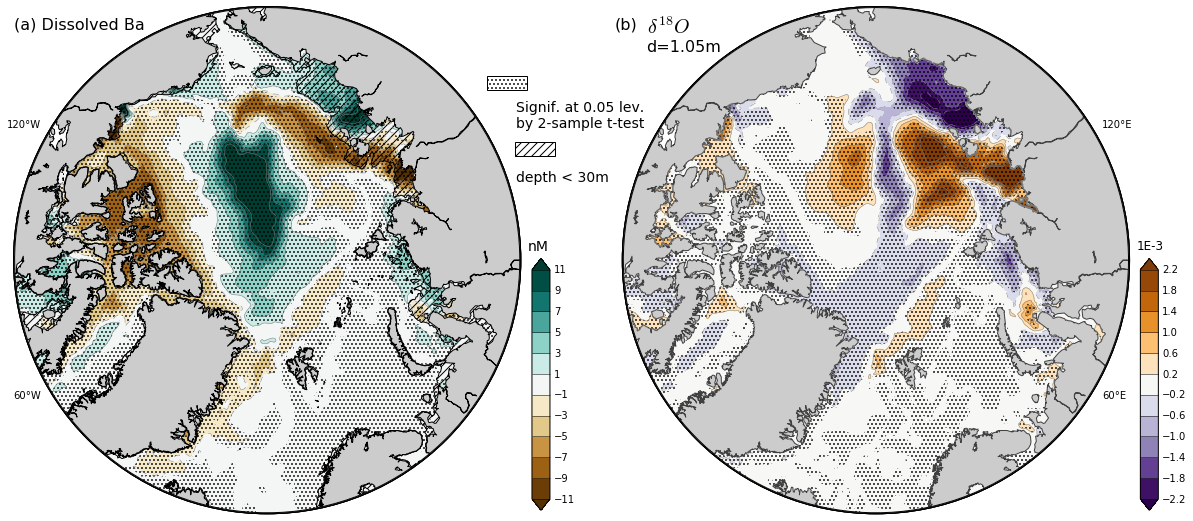

In [26]:
cmap_scale1 = 1.0
cmap_scale2 = 0.2
# figure size as inches
fig=plt.figure(figsize=(20, 10));
# set map boundaries
theta = np.linspace(0, 2*np.pi, 150)
center, radius = [0.5, 0.5], 0.498
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
# ======================================== figure a ======================================== #
# background axis
ax_background1 = plt.subplot(1, 2, 1)
patch = patches.PathPatch(circle, lw=4)
ax_background1.add_patch(patch)
ax_background1.axis('off')
# projection axis
ax_proj1 = plt.subplot(1, 2, 1, projection=cartopy.crs.NorthPolarStereo(0))
ax_proj1.set_extent([-180, 180, 65, 90], cartopy.crs.PlateCarree())
ax_proj1.set_boundary(circle, transform=ax_proj1.transAxes)
# basemap @ projection axis
# "proj0" and "proj" --> a hack of basemap's labeling problem 
proj0=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=True, ax=ax_proj1)
proj0.drawmeridians(np.array([240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=False, ax=ax_proj1)
proj.drawcoastlines(linewidth=1.0, color='k')
proj.fillcontinents(color='0.8', lake_color=None)
x0, y0 = proj(nav_lon, nav_lat)
# contour Ba
CS1 = proj.contourf(x0, y0, dBa, lev_dT*cmap_scale1, cmap=plt.cm.BrBG, extend='both')
proj.contour(x0, y0, dBa, lev_dT*cmap_scale1, colors='gray', linewidths=0.5)
CS2 = proj.contourf(x0, y0, gridT_mask, [0, 0.5], hatches=['///'], colors='none')
proj.contour(x0, y0, gridT_mask, [0], linewidths=1.0, colors='k')
CS3 = proj.contourf(x0, y0, Ba_id, [0.5, 1.0], hatches=['...'], colors='none')
# dep < 30m
artists, _ = CS2.legend_elements()
labels = ['']
LG = ax_proj1.legend(artists, labels, bbox_to_anchor=(1.135, 0.77), prop={'size':20}); LG.draw_frame(False)
ax_proj1.text(0.56e7, 0.37e7, 'depth < 30m', fontsize=14)
# Ba colorbar
cax = fig.add_axes([0.485, 0.165, 0.0125, 0.35])
CBar = fig.colorbar(CS1, cax=cax, orientation='vertical')
CBar.set_label('nM', fontsize=14, labelpad=-37, y=1.075, rotation=0)
CBar.ax.tick_params(axis='y', length=18)
CBar.ax.xaxis.set_label_position('top')
CBar.set_ticks(lev_dT*cmap_scale1)
# title
ax_proj1.set_title('(a) Dissolved Ba', x=0, y=0.97, va='top', loc='left', fontsize=16)
# ======================================== figure b ======================================== #
# background axis
ax_background2 = plt.subplot(1, 2, 2)
patch = patches.PathPatch(circle, lw=4)
ax_background2.add_patch(patch)
ax_background2.axis('off')
# projection axis
ax_proj2 = plt.subplot(1, 2, 2, projection=cartopy.crs.NorthPolarStereo(0))
ax_proj2.set_extent([-180, 180, 65, 90], cartopy.crs.PlateCarree())
ax_proj2.set_boundary(circle, transform=ax_proj2.transAxes)
# basemap @ projection axis
proj0=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=True, ax=ax_proj2)
proj0.drawmeridians(np.array([60, 120]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=False, ax=ax_proj2)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=1.0, color='0.25')
x0, y0 = proj(nav_lon, nav_lat)
# contour d18O
CS1 = proj.contourf(x0, y0, dd18O, lev_dT*cmap_scale2, cmap=plt.cm.PuOr_r, extend='both')
proj.contour(x0, y0, dd18O, lev_dT*cmap_scale2, colors='gray', linewidths=0.5)
proj.contourf(x0, y0, d18O_id, [0.5, 1.0], hatches=['...'], colors='none')
# sig = 0.05
artists, _ = CS3.legend_elements()
labels = ['']
LG = ax_proj2.legend(artists, labels, bbox_to_anchor=(-0.12, 0.9), prop={'size':20}); LG.draw_frame(False)
ax_proj1.text(0.56e7, 0.43e7, 'Signif. at 0.05 lev.\nby 2-sample t-test', fontsize=14)
# d18O colorbar
cax = fig.add_axes([0.9075, 0.165, 0.0125, 0.35])
CBar = fig.colorbar(CS1, cax=cax, orientation='vertical')
CBar.set_label('1E-3', fontsize=12, labelpad=-36, y=1.075, rotation=0)
CBar.ax.tick_params(axis='y', length=18)
CBar.ax.xaxis.set_label_position('top')
CBar.set_ticks(lev_dT*cmap_scale2)
ax_proj2.set_title("(b)",
                   x=-0.015, y=0.97, va='top', loc='left', fontsize=16)
ax_proj2.text(0.027e7, 0.535e7, r"$\delta^{18}O$", fontsize=20)
ax_proj2.text(0.027e7, 0.515e7, "d=1.05m", fontsize=16)
# ======================================== Figure export ======================================== #
#fig.savefig('pdf_test4.pdf', dpi=100, orientation='portrait', papertype='a4', format='pdf',
#                bbox_inches='tight', pad_inches=0.1)

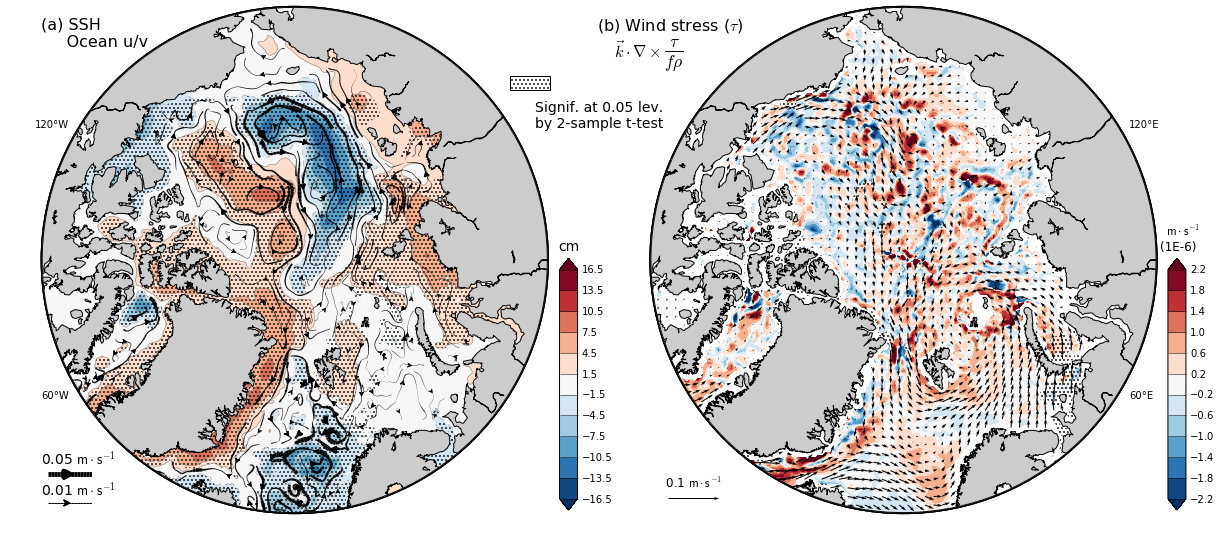

In [40]:
cmap_scale1 = 1.5
cmap_scale2 = 0.2
# figure size as inches
fig=plt.figure(figsize=(20, 10));
# set map boundaries
theta = np.linspace(0, 2*np.pi, 150)
center, radius = [0.5, 0.5], 0.498
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
# ======================================== figure a ======================================== #
# background axis
ax_background1 = plt.subplot(1, 2, 1)
patch = patches.PathPatch(circle, lw=4)
ax_background1.add_patch(patch)
ax_background1.axis('off')
# projection axis
ax_proj1 = plt.subplot(1, 2, 1, projection=cartopy.crs.NorthPolarStereo(0))
ax_proj1.set_extent([-180, 180, 65, 90], cartopy.crs.PlateCarree())
ax_proj1.set_boundary(circle, transform=ax_proj1.transAxes)
# basemap @ projection axis
# "proj0" and "proj" --> a hack of basemap's labeling problem 
proj0=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=True, ax=ax_proj1)
proj0.drawmeridians(np.array([240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=False, ax=ax_proj1)
proj.drawcoastlines(linewidth=1.0, color='k')
proj.fillcontinents(color='0.8', lake_color=None)
x0, y0 = proj(nav_lon, nav_lat)
# interpolate vectors
uproj, vproj = proj.rotate_vector(zc_regrid, mc_regrid, ocean_lon2, ocean_lat2, returnxy=False)
uproj_rec, x, y = proj.transform_scalar(uproj, ocean_x2, ocean_y2, 400, 400, returnxy=True)
vproj_rec, _, _ = proj.transform_scalar(vproj, ocean_x2, ocean_y2, 400, 400, returnxy=True)
# contour ssh
CS1 = proj.contourf(x0, y0, dssh*1e2, lev_dT*cmap_scale1, cmap=plt.cm.RdBu_r, extend='both')
proj.contour(x0, y0, dssh*1e2, lev_dT*cmap_scale1, colors='gray', linewidths=0.5)
CS2 = proj.contourf(x0, y0, ssh_id, [0.5, 1.0], hatches=['...'], colors='none')
# legend proxy for the hatch
artists, _ = CS2.legend_elements()
labels = ['']
LG = ax_proj1.legend(artists, labels, bbox_to_anchor=(1.07, 0.9), prop={'size':20}); LG.draw_frame(False)
ax_proj1.text(0.55e7, 0.43e7, 'Signif. at 0.05 lev.\nby 2-sample t-test', fontsize=14)
# ocean u/v stream line
speed = np.sqrt(uproj_rec**2+vproj_rec**2)
lw = 10*speed/np.nanmax(speed)
lw[lw==np.inf]=0; lw[np.isnan(lw)]=0 # --> Figure object contains "np.inf" causes error when exporting pdf
proj.streamplot(x, y, uproj_rec, vproj_rec, density=[5, 2], color='k', linewidth=lw, \
                arrowstyle='fancy', arrowsize=1, zorder=4)
# <----- A hack of streamplot legend
# 0.1m/s mark
mark_spd = 0.05
lgd_x, lgd_y = np.meshgrid(np.linspace(0, 1, 2), np.linspace(0, 1, 2))
lgd_u = np.ones([2, 2])*mark_spd
lgd_v = np.zeros([2, 2])
legend_ax1 = fig.add_axes([0.13, 0.2, 0.03, 0.03])
legend_ax1.streamplot(lgd_x, lgd_y, lgd_u, lgd_v, color='k', 
                     linewidth=10*mark_spd/np.nanmax(speed), arrowstyle='fancy', arrowsize=1.5)
legend_ax1.set_ylim([-0.01, 0.01])
legend_ax1.axis('off')
# 0.01 m/s mark
mark_spd = 0.01
lgd_u = np.ones([2, 2])*mark_spd
lgd_v = np.zeros([2, 2])
legend_ax2 = fig.add_axes([0.13, 0.16, 0.03, 0.03])
legend_ax2.streamplot(lgd_x, lgd_y, lgd_u, lgd_v, color='k', 
                     linewidth=10*mark_spd/np.nanmax(speed), arrowstyle='fancy', arrowsize=1.5)
legend_ax2.set_ylim([-0.01, 0.01])
legend_ax2.axis('off')
# labels
ax_proj1.text(0, 0.055e7, r'0.05 $\mathsf{m\cdot s^{-1}}$', fontsize=14)
ax_proj1.text(0, 0.02e7, r'0.01 $\mathsf{m\cdot s^{-1}}$', fontsize=14)
# ssh colorbar
cax = fig.add_axes([0.485, 0.165, 0.0125, 0.35])
CBar = fig.colorbar(CS1, cax=cax, orientation='vertical')
CBar.set_label('cm', fontsize=14, labelpad=-43.5, y=1.075, rotation=0)
CBar.ax.tick_params(axis='y', length=18)
CBar.ax.xaxis.set_label_position('top')
CBar.set_ticks(lev_dT*cmap_scale1)
# title
ax_proj1.set_title('(a) SSH\n     Ocean u/v', x=0, y=0.97, va='top', loc='left', fontsize=16)
# ======================================== figure b ======================================== #
# background axis
ax_background2 = plt.subplot(1, 2, 2)
patch = patches.PathPatch(circle, lw=4)
ax_background2.add_patch(patch)
ax_background2.axis('off')
# projection axis
ax_proj2 = plt.subplot(1, 2, 2, projection=cartopy.crs.NorthPolarStereo(0))
ax_proj2.set_extent([-180, 180, 65, 90], cartopy.crs.PlateCarree())
ax_proj2.set_boundary(circle, transform=ax_proj2.transAxes)
# basemap @ projection axis
proj0=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=True, ax=ax_proj2)
proj0.drawmeridians(np.array([60, 120]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=False, ax=ax_proj2)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=1.0, color='k')
x0, y0 = proj(nav_lon, nav_lat)
x1, y1 = proj(ocean_lon2, ocean_lat2)
# interpolate vectors
uproj, vproj = proj.rotate_vector(taux_regrid, tauy_regrid, ocean_lon2, ocean_lat2, returnxy=False)
uproj_rec, x, y = proj.transform_scalar(uproj, ocean_x2, ocean_y2, 60, 60, returnxy=True)
vproj_rec, _, _ = proj.transform_scalar(vproj, ocean_x2, ocean_y2, 60, 60, returnxy=True)
curlz_tau_rec, x3, y3 = proj.transform_scalar(curlz_tau*1e6, ocean_x2, ocean_y2, 200, 200, returnxy=True)
# contour wind stress curl
CS1 = proj.contourf(x3, y3, curlz_tau_rec, lev_dT*cmap_scale2, cmap=plt.cm.RdBu_r, extend='both')
proj.contourf(x0, y0, taux_id, [0.5, 1.0], hatches=['...'], colors='none')
# wind stress 
Q=proj.quiver(x, y, uproj_rec, vproj_rec, width=0.002, headwidth=3, scale=1.0, color='k', zorder=4)
qk = plt.quiverkey(Q, 0.56, 0.1825, 0.1, '\t      0.1 $\mathsf{m\cdot s^{-1}}$', \
                   labelpos='N', coordinates='figure', fontproperties={'size': 12})
cax = fig.add_axes([0.9075, 0.165, 0.0125, 0.35])
CBar = fig.colorbar(CS1, cax=cax, orientation='vertical')
CBar.set_label('$\mathsf{\ \ \ m\cdot s^{-1}}$\n(1E-6)', fontsize=12, labelpad=-36, y=1.14, rotation=0)
CBar.ax.tick_params(axis='y', length=18)
CBar.ax.xaxis.set_label_position('top')
CBar.set_ticks(lev_dT*cmap_scale2)
ax_proj2.set_title(
    r'(b) Wind stress ($\mathrm{\tau}$)', x=-0.105, y=0.97, va='top', loc='left', fontsize=16)
ax_proj2.text(-0.04e7, 0.509e7, r'$\vec{k}\cdot\nabla\times$', fontsize=16)
ax_proj2.text(0.0155e7, 0.509e7, r'$\frac{\tau}{f\rho}$', fontsize=25)
# ======================================== Figure export ======================================== #
#fig.savefig('pdf_test2.pdf', dpi=100, orientation='portrait', papertype='a4', format='pdf',
#                bbox_inches='tight', pad_inches=0.1)

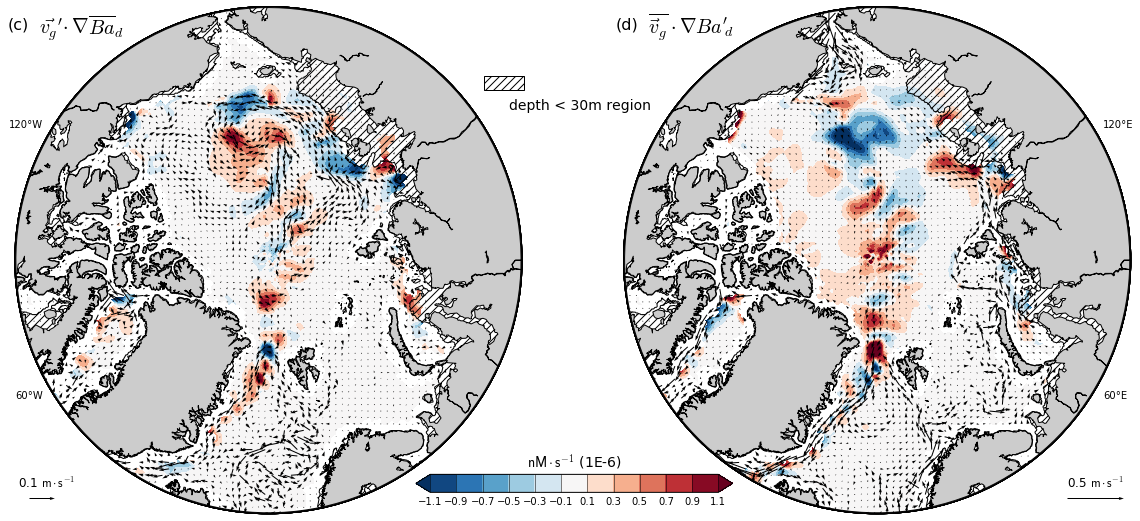

In [27]:
cmap_scale1 = 0.1
cmap_scale2 = 0.1
# figure size as inches
fig=plt.figure(figsize=(20, 10));
# set map boundaries
theta = np.linspace(0, 2*np.pi, 150)
center, radius = [0.5, 0.5], 0.498
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
# ======================================== figure a ======================================== #
# background axis
ax_background1 = plt.subplot(1, 2, 1)
patch = patches.PathPatch(circle, lw=4)
ax_background1.add_patch(patch)
ax_background1.axis('off')
# projection axis
ax_proj1 = plt.subplot(1, 2, 1, projection=cartopy.crs.NorthPolarStereo(0))
ax_proj1.set_extent([-180, 180, 65, 90], cartopy.crs.PlateCarree())
ax_proj1.set_boundary(circle, transform=ax_proj1.transAxes)
# basemap @ projection axis
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=True, ax=ax_proj1)
proj.drawmeridians(np.array([240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
proj.drawcoastlines(linewidth=1.0, color='k')
proj.fillcontinents(color='0.8', lake_color=None)
x0, y0 = proj(nav_lon, nav_lat)
#x1, y1 = proj(ocean_lon, ocean_lat)
# interpolate variables
uproj, vproj = proj.rotate_vector(ug1, vg1, ocean_lon2, ocean_lat2, returnxy=False)
uproj_rec, x, y = proj.transform_scalar(uproj, ocean_x2, ocean_y2, 80, 80, returnxy=True)
vproj_rec, _, _ = proj.transform_scalar(vproj, ocean_x2, ocean_y2, 80, 80, returnxy=True)
Ba_adv_rec, x1, y1 = proj.transform_scalar(Ba_adv1*1e6, ocean_x, ocean_y, 200, 200, returnxy=True)
# contour adv
CS1 = proj.contourf(x1, y1, Ba_adv_rec, lev_dT*cmap_scale1, cmap=plt.cm.RdBu_r, extend='both')
CS2 = proj.contourf(x0, y0, gridT_mask, [0, 0.5], hatches=['///'], colors='none')
proj.contour(x0, y0, gridT_mask, [0], linewidths=1.0, colors='k')
# velocity arrows
Q=proj.quiver(x, y, uproj_rec, vproj_rec, width=0.002, headwidth=3, scale=2.0, color='k')
qk = plt.quiverkey(Q, 0.135, 0.1825, 0.1, r'         0.1 $\mathsf{m\cdot s^{-1}}$', \
                   labelpos='N', coordinates='figure', fontproperties={'size': 12})
# shallow region
artists, _ = CS2.legend_elements()
labels = ['']
LG = ax_proj1.legend(artists, labels, bbox_to_anchor=(1.07, 0.9), prop={'size':20}); LG.draw_frame(False)
ax_proj1.text(0.55e7, 0.45e7, 'depth < 30m region', fontsize=14)
# title
ax_proj1.set_title("(c)", 
                   x=-0.015, y=0.97, va='top', loc='left', fontsize=16)
ax_proj1.text(0.027e7, 0.535e7, r"$\vec{v_{g}}'\cdot\nabla{\overline{Ba}_d}$", fontsize=20)
# ======================================== figure b ======================================== #
# background axis
ax_background2 = plt.subplot(1, 2, 2)
patch = patches.PathPatch(circle, lw=4)
ax_background2.add_patch(patch)
ax_background2.axis('off')
# projection axis
ax_proj2 = plt.subplot(1, 2, 2, projection=cartopy.crs.NorthPolarStereo(0))
ax_proj2.set_extent([-180, 180, 65, 90], cartopy.crs.PlateCarree())
ax_proj2.set_boundary(circle, transform=ax_proj2.transAxes)
# basemap @ projection axis
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=True, ax=ax_proj2)
proj.drawmeridians(np.array([60, 120]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
proj.drawcoastlines(linewidth=1.0, color='k')
proj.fillcontinents(color='0.8', lake_color=None)
x0, y0 = proj(nav_lon, nav_lat)
#x1, y1 = proj(ocean_lon, ocean_lat)
# interpolate variables
uproj, vproj = proj.rotate_vector(ug2, vg2, ocean_lon2, ocean_lat2, returnxy=False)
uproj_rec, x, y = proj.transform_scalar(uproj, ocean_x2, ocean_y2, 80, 80, returnxy=True)
vproj_rec, _, _ = proj.transform_scalar(vproj, ocean_x2, ocean_y2, 80, 80, returnxy=True)
Ba_adv_rec, x1, y1 = proj.transform_scalar(Ba_adv2*1e6, ocean_x, ocean_y, 200, 200, returnxy=True)
# contour slp
CS1 = proj.contourf(x1, y1, Ba_adv_rec, lev_dT*cmap_scale2, cmap=plt.cm.RdBu_r, extend='both')
CS2 = proj.contourf(x0, y0, gridT_mask, [0, 0.5], hatches=['///'], colors='none')
proj.contour(x0, y0, gridT_mask, [0], linewidths=1.0, colors='k')
# velocity arrows
Q=proj.quiver(x, y, uproj_rec, vproj_rec, width=0.002, headwidth=3, scale=4.5, color='k')
qk = plt.quiverkey(Q, 0.856, 0.1825, 0.5, r'               0.5 $\mathsf{m\cdot s^{-1}}$', \
                   labelpos='N', coordinates='figure', fontproperties={'size': 12})
# adv colorbar
cax = fig.add_axes([0.4035, 0.19, 0.22, 0.025])
CBar = fig.colorbar(CS1, cax=cax, orientation='horizontal')
CBar.set_label('$\mathsf{nM\cdot s^{-1}}$ (1E-6)', labelpad=7.5, fontsize=14, rotation=0)
CBar.ax.tick_params(axis='x', length=18)
CBar.ax.xaxis.set_label_position('top')
CBar.set_ticks(lev_dT*cmap_scale2)
# title
ax_proj2.set_title("(d)", 
                   x=-0.015, y=0.97, va='top', loc='left', fontsize=16)
ax_proj2.text(0.027e7, 0.535e7, r"$\overline{\vec{v}_g}\cdot\nabla{Ba'_d}$", fontsize=20)
# ======================================== Figure export ======================================== #
#fig.savefig('pdf_test3.pdf', dpi=100, orientation='portrait', papertype='a4', format='pdf',
#                bbox_inches='tight', pad_inches=0.1)

(0.0, 1.0, 0.0, 1.0)

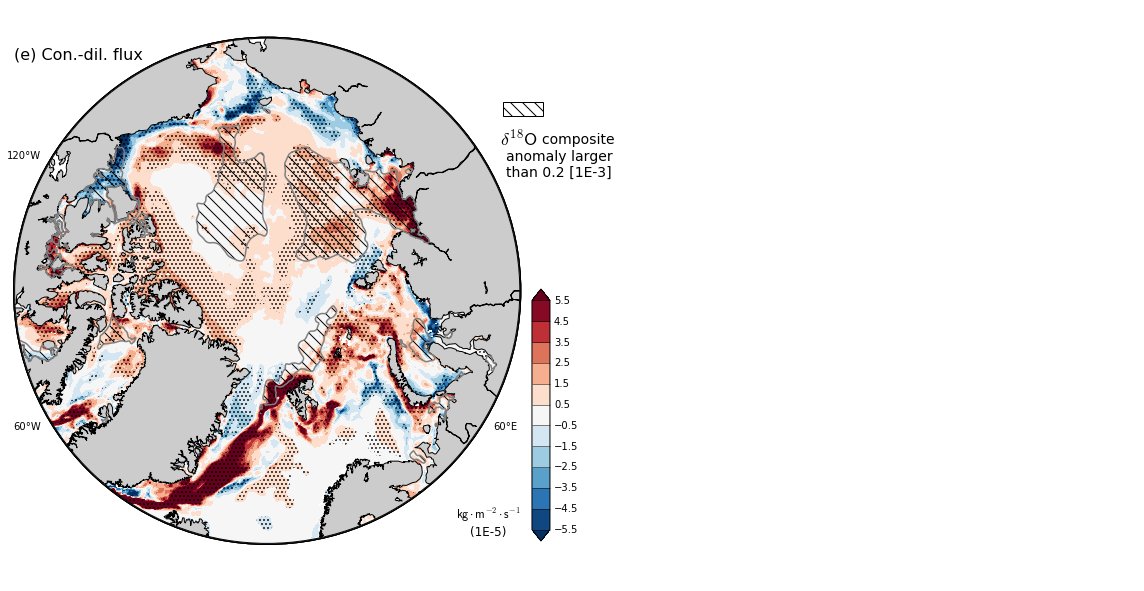

In [39]:
cmap_scale1 = 0.5
# figure size as inches
fig=plt.figure(figsize=(20, 10));
# set map boundaries
theta = np.linspace(0, 2*np.pi, 150)
center, radius = [0.5, 0.5], 0.498
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
# ======================================== figure a ======================================== #
# background axis
ax_background1 = plt.subplot(1, 2, 1)
patch = patches.PathPatch(circle, lw=4)
ax_background1.add_patch(patch)
ax_background1.axis('off')
# projection axis
ax_proj1 = plt.subplot(1, 2, 1, projection=cartopy.crs.NorthPolarStereo(0))
ax_proj1.set_extent([-180, 180, 65, 90], cartopy.crs.PlateCarree())
ax_proj1.set_boundary(circle, transform=ax_proj1.transAxes)
# basemap @ projection axis
# "proj0" and "proj" --> a hack of basemap's labeling problem 
proj0=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=True, ax=ax_proj1)
proj0.drawmeridians(np.array([60, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=0, round=False, ax=ax_proj1)
proj.drawcoastlines(linewidth=1.0, color='k')
proj.fillcontinents(color='0.8', lake_color=None)
x0, y0 = proj(nav_lon, nav_lat)
# contour emps
CS1 = proj.contourf(x0, y0, demps*1e5, lev_dT*cmap_scale1, cmap=plt.cm.RdBu_r, extend='both')
proj.contourf(x0, y0, emps_id, [0.5, 1.0], hatches=['...'], colors='none')
proj.contour(x0, y0, dd18O, [0.2], colors='gray', linewidths=1.5)
CS2 = proj.contourf(x0, y0, dd18O, [0.2, 100], hatches=['\\\\'], colors='none')
# legend proxy for the hatch
artists, _ = CS2.legend_elements()
labels = ['']
LG = ax_proj1.legend(artists, labels, bbox_to_anchor=(1.11, 0.91), prop={'size':20}); LG.draw_frame(False)
ax_proj1.text(0.542e7, 0.445e7, r'$\mathsf{\delta^{18}O}$', fontsize=18)
ax_proj1.text(0.548e7, 0.41e7, '        composite\nanomaly larger\nthan 0.2 [1E-3]', fontsize=14)
# emps colorbar
cax = fig.add_axes([0.485, 0.165, 0.0125, 0.35])
CBar = fig.colorbar(CS1, cax=cax, orientation='vertical')
CBar.set_label('$\mathsf{kg\cdot m^{-2}\cdot s^{-1}}$\n(1E-5)', fontsize=12, labelpad=-90, y=0.15, rotation=0)
CBar.ax.tick_params(axis='y', length=18)#labelpad=-15, y=1.175
CBar.ax.xaxis.set_label_position('top')
CBar.set_ticks(lev_dT*cmap_scale1)
# title
ax_proj1.set_title('(e) Con.-dil. flux', x=0, y=0.97, va='top', loc='left', fontsize=16)
# ======================================== figure b ======================================== #
ax_background2 = plt.subplot(1, 2, 2)
ax_background2.axis('off')
# ======================================== Figure export ======================================== #
#fig.savefig('pdf_test5.pdf', dpi=100, orientation='portrait', papertype='a4', format='pdf',
#                bbox_inches='tight', pad_inches=0.1)

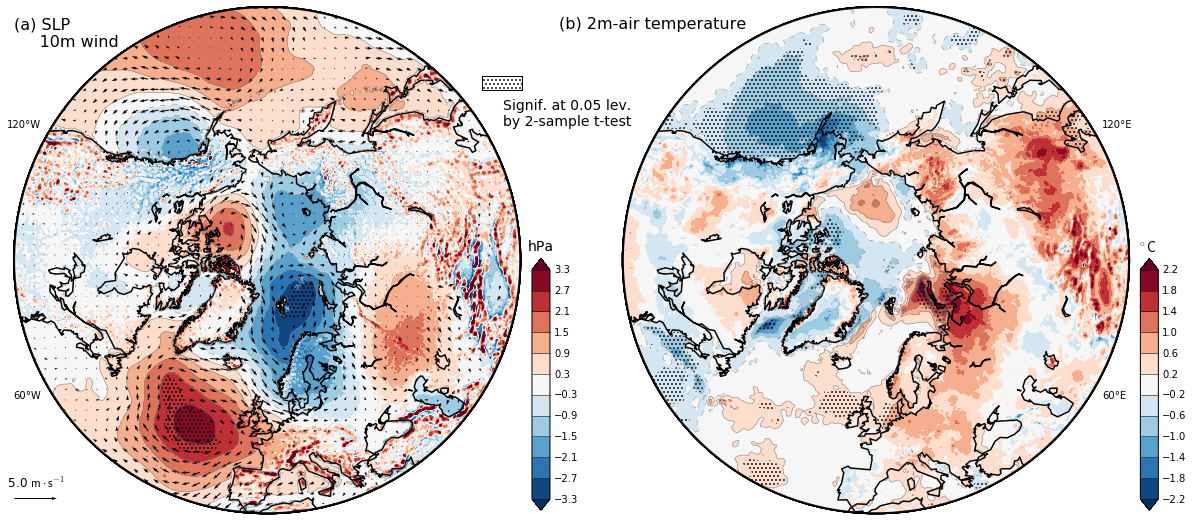

In [41]:
cmap_scale1 = 0.3
cmap_scale2 = 0.2
# figure size as inches
fig=plt.figure(figsize=(20, 10));
# set map boundaries
theta = np.linspace(0, 2*np.pi, 150)
center, radius = [0.5, 0.5], 0.498
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
# ======================================== figure a ======================================== #
# background axis
ax_background1 = plt.subplot(1, 2, 1)
patch = patches.PathPatch(circle, lw=4)
ax_background1.add_patch(patch)
ax_background1.axis('off')
# projection axis
ax_proj1 = plt.subplot(1, 2, 1, projection=cartopy.crs.NorthPolarStereo(0))
ax_proj1.set_extent([-180, 180, 35, 90], cartopy.crs.PlateCarree())
ax_proj1.set_boundary(circle, transform=ax_proj1.transAxes)
# basemap @ projection axis
proj=Basemap(projection='npstere', resolution='c', boundinglat=35, lon_0=0, round=True, ax=ax_proj1)
proj.drawmeridians(np.array([240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
proj.drawcoastlines(linewidth=1.5, color='k')
x0, y0 = proj(slp_lon, slp_lat)
# interpolate vectors
uproj, vproj = proj.rotate_vector(u_regrid, v_regrid, ocean_lon, ocean_lat, returnxy=False)
uproj_rec, x, y = proj.transform_scalar(uproj, ocean_x, ocean_y, 50, 50, returnxy=True)
vproj_rec, _, _ = proj.transform_scalar(vproj, ocean_x, ocean_y, 50, 50, returnxy=True)
# contour slp
CS1 = proj.contourf(x0, y0, dslp, lev_dT*cmap_scale1, cmap=plt.cm.RdBu_r, extend='both')
proj.contour(x0, y0, dslp_ocean, lev_dT*cmap_scale1, colors='gray', linewidths=0.5)
CS2 = proj.contourf(x0, y0, slp_id, [0.5, 1.0], hatches=['...'], colors='none')
# legend proxy for the hatch
artists, _ = CS2.legend_elements()
labels = ['']
LG = ax_proj1.legend(artists, labels, bbox_to_anchor=(1.07, 0.9), prop={'size':20}); LG.draw_frame(False)
ax_proj1.text(1.28e7, 1.015e7, 'Signif. at 0.05 lev.\nby 2-sample t-test', fontsize=14)
# 10m wind as arrows
Q=proj.quiver(x, y, uproj_rec, vproj_rec, width=0.002, headwidth=3, scale=60, color='k')
qk = plt.quiverkey(Q, 0.125, 0.1825, 5, '\t    5.0 $\mathsf{m\cdot s^{-1}}$', \
                   labelpos='N', coordinates='figure', fontproperties={'size': 12})
# slp colorbar
cax = fig.add_axes([0.485, 0.165, 0.0125, 0.35])
CBar = fig.colorbar(CS1, cax=cax, orientation='vertical')
CBar.set_label('hPa', fontsize=14, labelpad=-38, y=1.075, rotation=0)
CBar.ax.tick_params(axis='y', length=18)
CBar.ax.xaxis.set_label_position('top')
CBar.set_ticks(lev_dT*cmap_scale1)
# title
ax_proj1.set_title('(a) SLP\n     10m wind', x=0, y=0.97, va='top', loc='left', fontsize=16)
# ======================================== figure b ======================================== #
# background axis
ax_background2 = plt.subplot(1, 2, 2)
patch = patches.PathPatch(circle, lw=4)
ax_background2.add_patch(patch)
ax_background2.axis('off')
# projection axis
ax_proj2 = plt.subplot(1, 2, 2, projection=cartopy.crs.NorthPolarStereo(0))
ax_proj2.set_extent([-180, 180, 35, 90], cartopy.crs.PlateCarree())
ax_proj2.set_boundary(circle, transform=ax_proj2.transAxes)
# basemap @ projection axis
proj=Basemap(projection='npstere', resolution='c', boundinglat=35, lon_0=0, round=True, ax=ax_proj2)
proj.drawmeridians(np.array([60, 120]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
proj.drawcoastlines(linewidth=1.5, color='k')
x0, y0 = proj(slp_lon, slp_lat)
# contour 2m temperature
CS1 = proj.contourf(x0, y0, dt2, lev_dT*cmap_scale2, cmap=plt.cm.RdBu_r, extend='both')
proj.contour(x0, y0, dt2_ocean, lev_dT*cmap_scale2, colors='gray', linewidths=0.5)
CS2 = proj.contourf(x0, y0, t2_id, [0.5, 1.0], hatches=['...'], colors='none')
# colorbar 
cax = fig.add_axes([0.9075, 0.165, 0.0125, 0.35])
CBar = fig.colorbar(CS1, cax=cax, orientation='vertical')
CBar.set_label('$\mathsf{^\circ C}$', fontsize=14, labelpad=-40, y=1.075, rotation=0)
CBar.ax.tick_params(axis='y', length=18)
CBar.ax.xaxis.set_label_position('top')
CBar.set_ticks(lev_dT*cmap_scale2)
# title
ax_proj2.set_title('(b) 2m-air temperature', x=-0.125, y=0.97, va='top', loc='left', fontsize=16)
# ======================================== Figure export ======================================== #
#fig.savefig('pdf_test.pdf', dpi=100, orientation='portrait', papertype='a4', format='pdf',
#                bbox_inches='tight', pad_inches=0.1)